# ConVAE

### Imports

In [7]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LeakyReLU, Conv2D, RepeatVector, Flatten, Reshape, Lambda, Conv2DTranspose, UpSampling2D, concatenate
from keras import regularizers
from keras.constraints import UnitNorm, MaxNorm

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## HYPERPARAMS & OPTIONS

In [2]:
### DATA SELECTION ###
bkg_filename = "../background_Full_Test3.txt"
sig_filename = "../signal_Full_Test3.txt"
drop_PHI_columns = False
n_train = 25000
scaler = MinMaxScaler()

### OPTIONS ###
savePlots = False
plotsLocation = "./"

### AUTOENCODER ###
batch_size = 50
encoding_dim = 6
n_epoch= 20
leak=0.2

### Data loading & Preprocessing

In [3]:
bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)

def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
coordinate_change(sig_all)
coordinate_change(bkg_all)

if drop_PHI_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)

n_bkg = len(bkg_sel.iloc[:,:0])
n_sig = len(sig_sel.iloc[:,:0])
f_s = n_train/n_sig
f_b = n_train/n_bkg

print ("Number of BACKGROUND events:", n_bkg)
print ("%0.2f%% = %d" % (f_b*100, n_train), "used for TRAINING")
print ("%.2f%% = %d" % (f_b*100, n_train), "used for TESTING")
print ("%05.2f%% = %d" % ((1-2*f_b)*100, n_bkg - 2*n_train), "unused")
print ("Number of SIGNAL events:", n_sig)
print ("%.2f%% = %d" % (f_s*100, n_train), "used for TESTING")
print ("%.2f%% = %d" % ((1-f_s)*100, n_sig - n_train), "unused")
print ("\n")

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:2*n_train], sig_sel.iloc[:n_train]])
sample_test = sample_test.reset_index(drop=True)

input_dim = sample_train.shape[1]

sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Training sample size: ',sample_train.shape)
print('Testing sample size: ',sample_test.shape)

sample_train_input, sample_train_valid = train_test_split(sample_train,test_size=0.2,random_state=13) 

Number of BACKGROUND events: 54194
46.13% = 25000 used for TRAINING
46.13% = 25000 used for TESTING
07.74% = 4194 unused
Number of SIGNAL events: 52766
47.38% = 25000 used for TESTING
52.62% = 27766 unused


Training sample size:  (25000, 13)
Testing sample size:  (50000, 13)


### Convolutional VAE

In [4]:
hidden_activation = 'linear'
encoder_activation = 'sigmoid'
decoder_activation = 'sigmoid'

encoder_in = Input(shape=(input_dim,), name='enc_in')
encoder_expand = Dense(128, activation=hidden_activation, name='enc_expand')(encoder_in)
activate_expand= LeakyReLU(alpha=leak)(encoder_expand)
encoder_reshape = Reshape((8,8,2), name='encoder_reshape')(activate_expand)
encoder_c1 = Conv2D(64, kernel_size=3, strides=1, padding="same", name='enc_c1')(encoder_reshape)
activate_ec1 = LeakyReLU(alpha=leak)(encoder_c1)
encoder_c2 = Conv2D(32, kernel_size=3, strides=1, padding="same", name='enc_c2')(activate_ec1)
activate_ec2 = LeakyReLU(alpha=leak)(encoder_c2)
encoder_c3 = Conv2D(16, kernel_size=3, strides=1, padding="same", name='enc_c3')(activate_ec2)
activate_ec3 = LeakyReLU(alpha=leak)(encoder_c3)
encoder_f1 = Flatten()(activate_ec3)
encoder_f2 = Dense(128, activation=hidden_activation, name='enc_f2') (encoder_f1)
activate_ef2 = LeakyReLU(alpha=leak)(encoder_f2)
mu = Dense(encoding_dim, activation=encoder_activation, name='mu_out')(activate_ef2)
log_sigma = Dense(encoding_dim, activation=encoder_activation, name='log_sigma_out')(activate_ef2)

encoder_out = [mu, log_sigma]
encoder = Model(encoder_in,encoder_out)

def sample_z(args):
    [mu, log_sigma] = args
    eps = K.random_normal(shape=(batch_size, encoding_dim), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps

def sample_z_train(args):
    [mu, log_sigma] = args
    eps = np.random.normal(0,1,size=(n_train, encoding_dim))
    return mu + np.exp(log_sigma / 2) * eps

def sample_z_test(args):
    [mu, log_sigma] = args
    eps = np.random.normal(0,1,size=(2*n_train, encoding_dim))
    return mu + np.exp(log_sigma / 2) * eps
z = Lambda(sample_z)(encoder_out)

decoder_f1 = Dense(128, activation=hidden_activation, name='dec_f1')
activate_df1 = LeakyReLU(alpha=leak)
decoder_reshape = Reshape((8,8,2), name='decoder_reshape')
decoder_c1 = Conv2DTranspose(64, kernel_size=2, strides=1, padding="same", name='dec_c1')
activate_dc1 = LeakyReLU(alpha=leak)
decoder_c2 = Conv2DTranspose(32, kernel_size=3, strides=1, padding="same", name='dec_c2')
activate_dc2 = LeakyReLU(alpha=leak)
decoder_c3 = Conv2DTranspose(16, kernel_size=3, strides=1, padding="same", name='dec_c3')
activate_dc3 = LeakyReLU(alpha=leak)
decoder_f2 = Flatten()
decoder_f3 = Dense(128, activation=hidden_activation, name='dec_f3')
activate_df4 = LeakyReLU(alpha=leak)
decoded = Dense(input_dim, activation=decoder_activation, name='dec_out')

h_d = decoder_f1(z)
h_d = activate_df1(h_d)
h_d = decoder_reshape(h_d)
h_d = decoder_c1(h_d)
h_d = activate_dc1(h_d)
h_d = decoder_c2(h_d)
h_d = activate_dc2(h_d)
h_d = decoder_c3(h_d)
h_d = activate_dc3(h_d)
h_d = decoder_f2(h_d)
h_d = decoder_f3(h_d)
h_d = activate_df4(h_d)
decoder_out = decoded(h_d)

autoencoder = Model(encoder_in, decoder_out)
autoencoder.summary()

d_in = Input(shape=(encoding_dim,))
l_d = decoder_f1(d_in)
l_d = activate_df1(l_d)
l_d = decoder_reshape(l_d)
l_d = decoder_c1(l_d)
l_d = activate_dc1(l_d)
l_d = decoder_c2(l_d)
l_d = activate_dc2(l_d)
l_d = decoder_c3(l_d)
l_d = activate_dc3(l_d)
l_d = decoder_f2(l_d)
l_d = decoder_f3(l_d)
l_d = activate_df4(l_d)
l_d = decoded(l_d)

decoder = Model(d_in, l_d)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 13)           0                                            
__________________________________________________________________________________________________
enc_expand (Dense)              (None, 128)          1792        enc_in[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 128)          0           enc_expand[0][0]                 
__________________________________________________________________________________________________
encoder_reshape (Reshape)       (None, 8, 8, 2)      0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
enc_c1 (Co

In [8]:
alpha = K.variable(0, dtype=float)
K.set_value(alpha, 1)

def changeAlpha(epoch,logs):
    K.set_value(alpha, 1)

class alphaChanger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        changeAlpha(epoch,logs)        
        
alphaUpdater = alphaChanger()

def KL_div(y_true, y_pred):
    return 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

def recon_mse(y_true, y_pred):
    return K.mean(K.square(y_pred-y_true), axis=1)

def vae_loss(y_true, y_pred):
    return KL_div(y_true, y_pred)*alpha + recon_mse(y_true, y_pred)

# Recording loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

autoencoder.compile(optimizer='adam', loss=vae_loss, metrics = [KL_div, recon_mse])

start = time.time()

vae_train = autoencoder.fit(sample_train_input, sample_train_input, batch_size=batch_size, epochs=n_epoch,
            shuffle=True, callbacks=[history, alphaUpdater],
            validation_data=(sample_train_valid, sample_train_valid))
    
end = time.time()
train_time = (end-start)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 162us/step - loss: 0.0481 - KL_div: 0.0200 - recon_mse: 0.0281 - val_loss: 0.0257 - val_KL_div: -1.0436e-16 - val_recon_mse: 0.0257
Epoch 2/20
20000/20000 [==============================] - 2s 96us/step - loss: 0.0258 - KL_div: -1.0107e-16 - recon_mse: 0.0258 - val_loss: 0.0256 - val_KL_div: -1.0436e-16 - val_recon_mse: 0.0256
Epoch 3/20
20000/20000 [==============================] - 2s 95us/step - loss: 0.0258 - KL_div: -1.0107e-16 - recon_mse: 0.0258 - val_loss: 0.0256 - val_KL_div: -1.0436e-16 - val_recon_mse: 0.0256
Epoch 4/20
20000/20000 [==============================] - 2s 99us/step - loss: 0.0258 - KL_div: -1.0107e-16 - recon_mse: 0.0258 - val_loss: 0.0256 - val_KL_div: -1.0436e-16 - val_recon_mse: 0.0256
Epoch 5/20
20000/20000 [==============================] - 2s 98us/step - loss: 0.0258 - KL_div: -1.0107e-16 - recon_mse: 0.0258 - val_loss: 0.0256 - val_KL_div: -1.043

### Loss

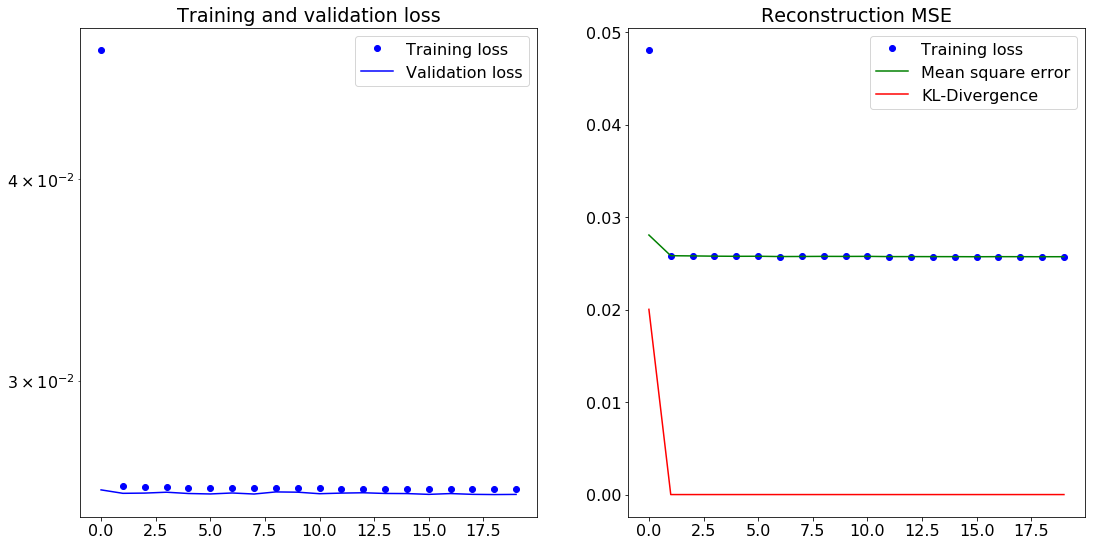

In [9]:
loss = vae_train.history['loss']
val_loss = vae_train.history['val_loss']
kl_div = vae_train.history['KL_div']
mse = vae_train.history['recon_mse']
epochs = range(n_epoch)
plt.figure(figsize=(18, 9))
plt.rcParams.update({'font.size': 16})
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, mse, 'g', label='Mean square error')
plt.plot(epochs, kl_div, 'red', label='KL-Divergence')
plt.title('Reconstruction MSE')
plt.legend()

plt.show()

if savePlots:
    plt.savefig(plotsLocation + "loss.png")

### Distances

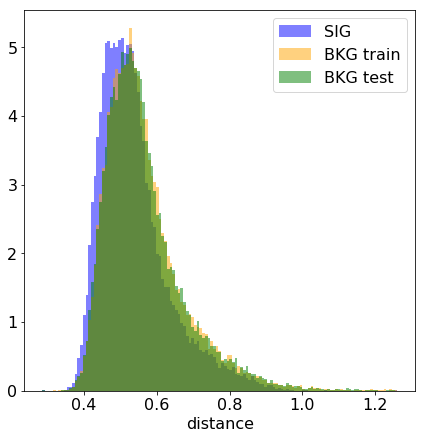

In [10]:
encoded_imgs = encoder.predict(sample_test)
decoded_imgs = decoder.predict(sample_z_test(encoded_imgs))

encoded_imgs_train = encoder.predict(sample_train)
decoded_imgs_train = decoder.predict(sample_z_train(encoded_imgs_train))


norm_bkg_test=[]
for i in range(sample_test.shape[0]//2):
    norm_bkg_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]
    
norm_sig=[]
for i in range(sample_test.shape[0]//2, sample_test.shape[0]):
    norm_sig += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_bkg_train=[]
for i in range(sample_train.shape[0]):
    norm_bkg_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]

plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_sig, bins='auto', alpha=0.5, label='SIG', color='blue', density=True)
plt.hist(norm_bkg_train, bins, alpha=0.5, label='BKG train', color='orange',density=True)
plt.hist(norm_bkg_test, bins, alpha=0.5, label='BKG test', color='green', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')
plt.show()
if savePlots:
    plt.savefig(plotsLocation + "distances.png")

### Encoding Variable Distribution

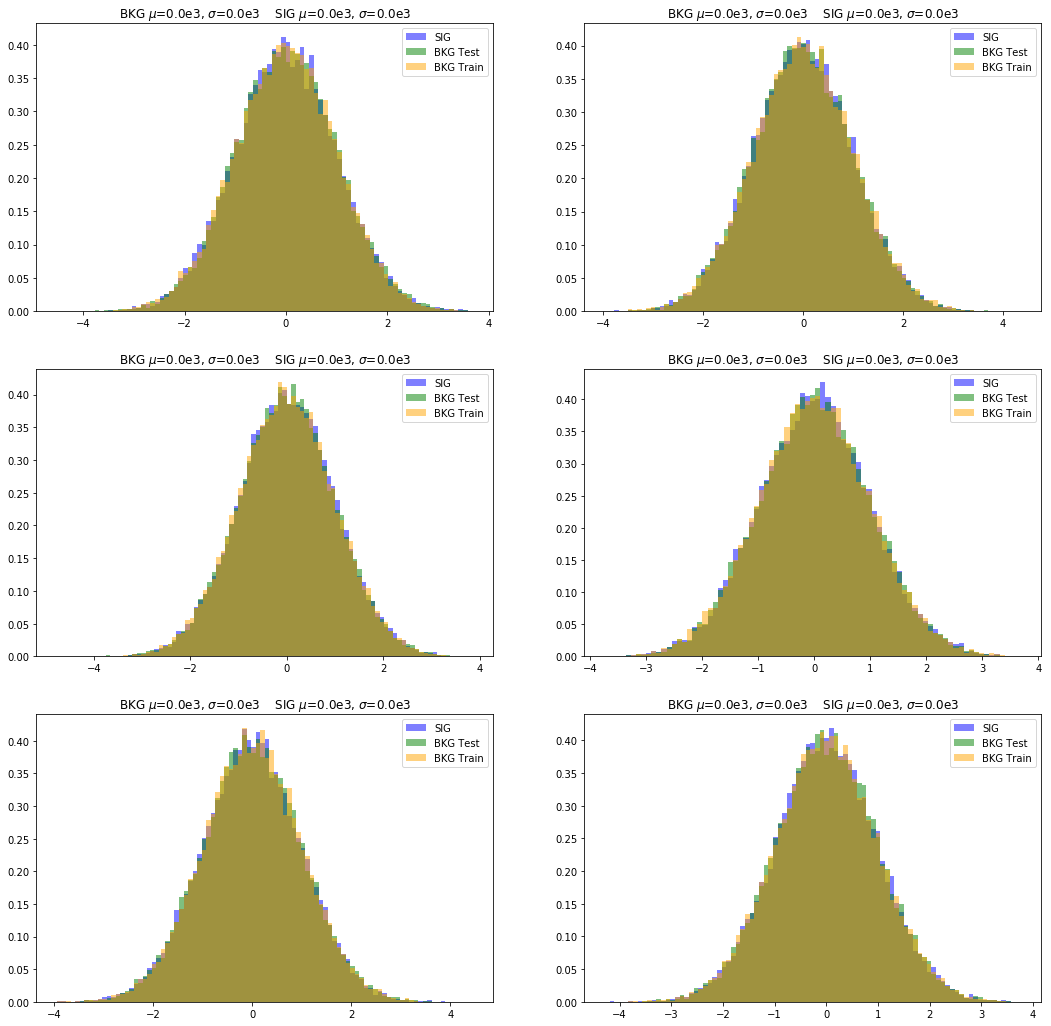

In [11]:
plt.figure(figsize=(18, 18))
plt.rcParams.update({'font.size': 10})
for i in range(encoding_dim):
    plt.subplot(3, 2, i+1)
    n, bins, patches=plt.hist(sample_z_train([encoded_imgs[0][sample_test.shape[0]//2:sample_test.shape[0],],encoded_imgs[1][sample_test.shape[0]//2:sample_test.shape[0],]])[:sample_test.shape[0]//2,i], bins='auto', alpha=0.5, label='SIG', color='blue', density=True)
    n, bins, patches=plt.hist(sample_z_train([encoded_imgs[0][:sample_test.shape[0]//2,],encoded_imgs[1][:sample_test.shape[0]//2,]])[:sample_test.shape[0]//2,i], bins=bins, alpha=0.5, label='BKG Test', color='green', density=True)
    n, bins, patches=plt.hist(sample_z_train([encoded_imgs_train[0][:sample_train.shape[0],],encoded_imgs_train[1][:sample_train.shape[0],]])[:sample_train.shape[0],i], bins=bins, alpha=0.5, label='BKG Train', color='orange', density=True)
    
    bkg_mu = 5e2*(np.mean(encoded_imgs_train[0][:sample_test.shape[0],i])
                  +np.mean(encoded_imgs[0][:sample_test.shape[0]//2,i]))
    bkg_sigma = 5e2*(np.mean(encoded_imgs_train[1][:sample_test.shape[0],i])
                      +np.mean(encoded_imgs[1][:sample_test.shape[0]//2,i]))
    bkg_stats = "BKG $\mu$=%.1fe3, $\sigma$=%.1fe3" % (bkg_mu, bkg_sigma)
    
    sig_mu = 10e2 * (np.mean(encoded_imgs[0][25000:50000,i]))
    sig_sigma = 10e2*(np.mean(encoded_imgs[1][25000:50000,i]))
    sig_stats=r'    SIG $\mu$=%.1fe3, $\sigma$=%.1fe3' % (sig_mu, sig_sigma)
    
    plt.title(bkg_stats+sig_stats)
    plt.legend(loc='best')
plt.show()

### ROC Curve

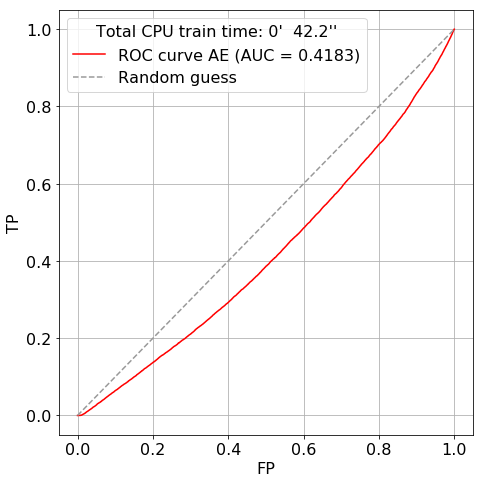

In [12]:
target = np.concatenate((np.zeros(sample_train.shape[0] + sample_test.shape[0]//2),np.ones(n_train)))
scores = np.concatenate((norm_bkg_train,norm_bkg_test, norm_sig))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(7, 7))
plt.rcParams.update({'font.size': 16})                  
fp, vp, thresholds = roc_curve(target,scores)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))
plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1], linestyle='--',color=(0.6, 0.6, 0.6), label='Random guess')
plt.grid()
plt.legend(loc="best", title =time_stamp)
plt.tight_layout()

if savePlots:
    plt.savefig(plotLocation + "ROC.png")

### Reconstruction

##### Training Data

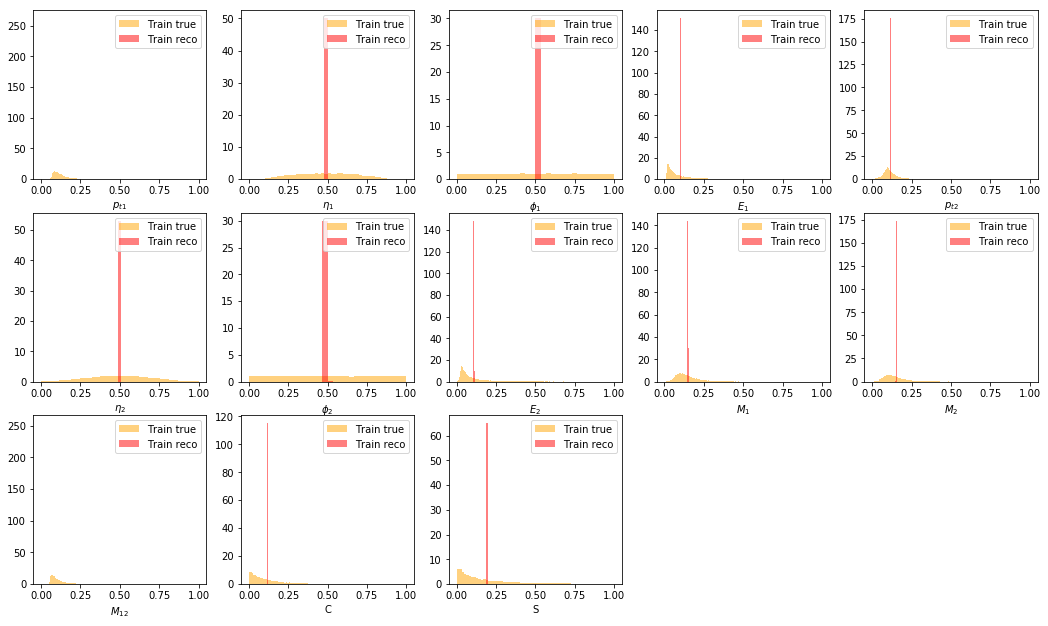

In [13]:
plt.figure(figsize=(18, 18))
plt.rcParams.update({'font.size': 10})
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches=plt.hist(sample_train[:,i], bins='auto', alpha=0.5, label='Train true',color='orange', density=True)
    plt.hist(decoded_imgs_train[:,i], bins=bins, alpha=0.5, label='Train reco',color='red' , density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')

##### New Background

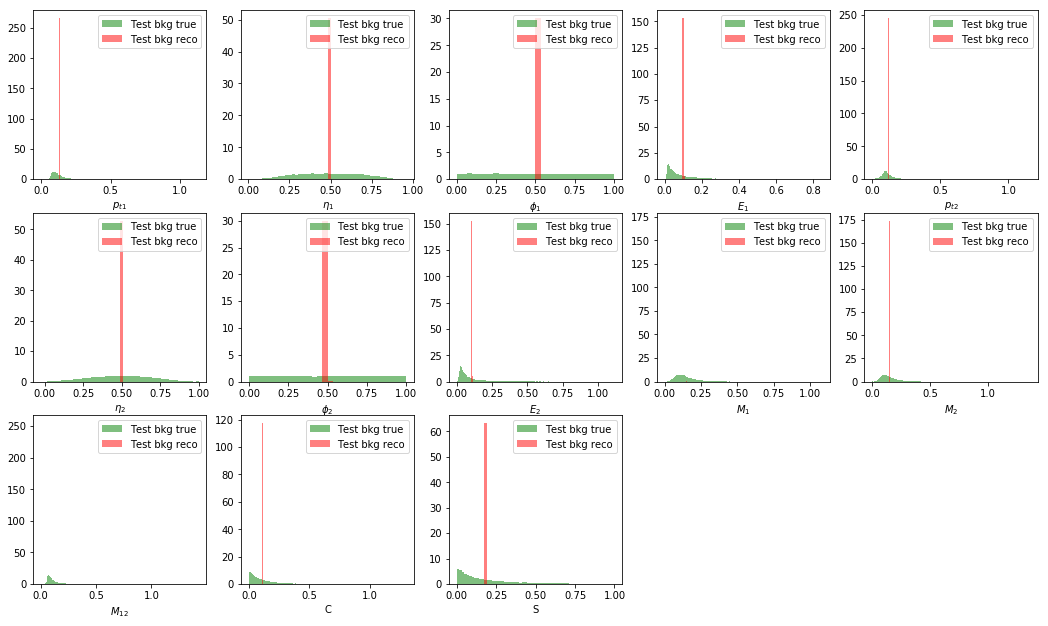

In [14]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[:sample_test.shape[0]//2,i], bins='auto', alpha=0.5, label='Test bkg true', color='green', density=True)
    n, bins, patches = plt.hist(decoded_imgs[:sample_test.shape[0]//2,i], bins, alpha=0.5, label='Test bkg reco', color='red', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')
    

##### Signal

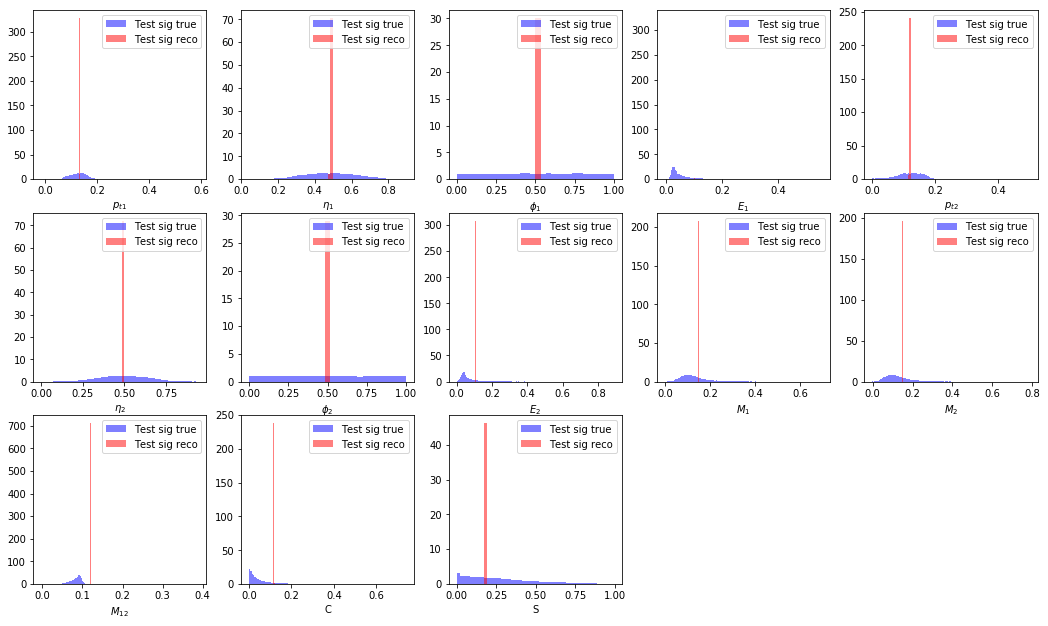

In [15]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[sample_test.shape[0]//2:sample_test.shape[0],i], bins='auto', alpha=0.5, label='Test sig true', color='blue', density=True)
    n, bins, patches = plt.hist(decoded_imgs[sample_test.shape[0]//2:sample_test.shape[0],i], bins, alpha=0.5, label='Test sig reco', color='red', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')